#### 导入库

In [3]:
import torch
import pandas 
import os 
from torchvision import transforms,models,datasets
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm 
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt 
import glob
from PIL import Image
from torch import nn
from torch.utils.data import random_split
torch.__version__


'1.11.0'

In [1]:
data_dir ='./fish_image23/fish_image/'

In [2]:
os.listdir(data_dir)

NameError: name 'os' is not defined

#### 数据集文件和鱼类名字映射

In [4]:

LAB_DICT = {'fish_1': 'Dascyllus reticulatus', 'fish_2': 'Plectroglyphidodon dickii',
            'fish_3': 'Chromis chrysura', 'fish_4': 'Amphiprion clarkii',
            'fish_5': 'Chaetodon lunulatus', 'fish_6': 'Chaetodon trifascialis',
            'fish_7': 'Myripristis kuntee', 'fish_8': 'Acanthurus nigrofuscus',
            'fish_9': 'Hemigymnus fasciatus', 'fish_10': 'Neoniphon sammara',
            'fish_11': 'Abudefduf vaigiensis', 'fish_12': 'Canthigaster valentini',
            'fish_13': 'Pomacentrus moluccensis', 'fish_14': 'Zebrasoma scopas',
            'fish_15': 'Hemigymnus melapterus', 'fish_16': 'Lutjanus fulvus',
            'fish_17': 'Scolopsis bilineata', 'fish_18': 'Scaridae',
            'fish_19': 'Pempheris vanicolensis', 'fish_20': 'Zanclus cornutus',
            'fish_21': 'Neoglyphidodon nigroris', 'fish_22': 'Balistapus undulatus',
            'fish_23': 'Siganus fuscescens'}     # 用于将文件名和标签相对应


In [9]:
class_names = [f for f in os.listdir(data_dir) if not f.startswith('.')]
num_class = len(class_names)
print(f'鱼类的数量: {num_class}' )
image_files = glob.glob(data_dir+'*/*.png',recursive=True)
image_files_length = len(image_files)
# # 一共是数据集的个数
print(f'数据集的个数 : {len(image_files)}')

鱼类的数量: 23
数据集的个数 : 27324


#### 将标签信息用 数字表示

In [14]:
# idx_to_class = { i :j for i ,j in enumerate(class_names)}
# class_to_idx = {value:key for key ,value in idx_to_class.items()}
# print(idx_to_class)

ls = {x.split('_')[1] : LAB_DICT[x] for x in  class_names and LAB_DICT }
ls

{'1': 'Dascyllus reticulatus',
 '2': 'Plectroglyphidodon dickii',
 '3': 'Chromis chrysura',
 '4': 'Amphiprion clarkii',
 '5': 'Chaetodon lunulatus',
 '6': 'Chaetodon trifascialis',
 '7': 'Myripristis kuntee',
 '8': 'Acanthurus nigrofuscus',
 '9': 'Hemigymnus fasciatus',
 '10': 'Neoniphon sammara',
 '11': 'Abudefduf vaigiensis',
 '12': 'Canthigaster valentini',
 '13': 'Pomacentrus moluccensis',
 '14': 'Zebrasoma scopas',
 '15': 'Hemigymnus melapterus',
 '16': 'Lutjanus fulvus',
 '17': 'Scolopsis bilineata',
 '18': 'Scaridae',
 '19': 'Pempheris vanicolensis',
 '20': 'Zanclus cornutus',
 '21': 'Neoglyphidodon nigroris',
 '22': 'Balistapus undulatus',
 '23': 'Siganus fuscescens'}

#### 分割数据集
- 分成训练集，验证集，测试集
- 训练集用来训练模型
- 验证集用来看训练模型是否欠拟合或者过拟合
- 测试集测试未知数据

#### 将数据集按照 7:2:1比例划分 

In [16]:
# 数据集划分的比例 7:2 ：1 
train_split_weight ,valid_split_weght,test_split_weight = 0.7,0.2,0.1
# 训练集的数量
train_length = int(image_files_length*train_split_weight)
# 验证集的数量
valit_length = int(image_files_length*valid_split_weght)
#测试集的数量
test_length = image_files_length - train_length - valit_length
# 划分
train_dataset,valid_dataset, test_dataset = random_split(
    dataset=image_files,
    lengths=[train_length,valit_length,test_length],
    generator=torch.Generator().manual_seed(0)
)
print(f'Training length : {len(train_dataset)}')
print(f'Valid length : {len(valid_dataset)}' )
print(f'Test length : {len(test_dataset)}')


Training length : 19126
Valid length : 5464
Test length : 2734


#### 获取训练集 ，验证集，测试集的图片的地址path 

In [17]:

train_list = [image_files[i] for i in train_dataset.indices]
valid_list = [image_files[i] for i in valid_dataset.indices] 
test_list =[ image_files[i] for i in test_dataset.indices]
print(len(test_list))

### 可视化数据集

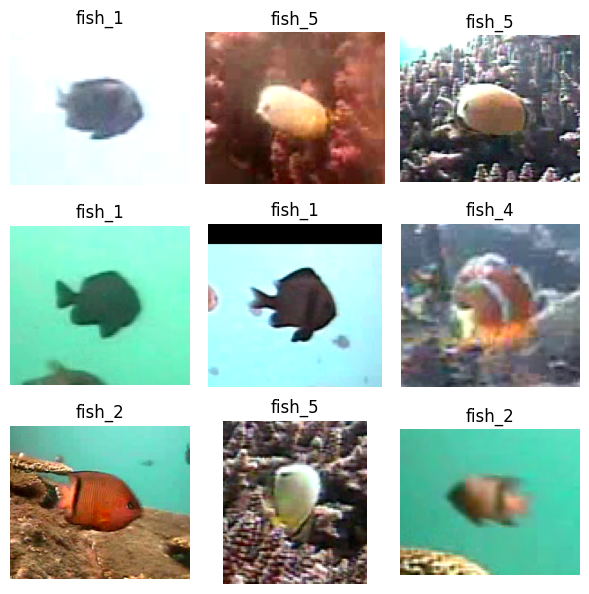

In [20]:
plt.subplots(3,3,figsize=(6,6))
# 大小不一致
for i , k in enumerate(np.random.randint(len(train_dataset),size=9)):
    im = Image.open(train_list[k])
    arr = np.array(im)
    plt.subplot(3,3,i+1)
    plt.axis('off')
    image_name = train_list[k].split('/')[-1]
    label = train_list[k].split("/")[-2]
    plt.title(f"{label}")
    
    # print(image_name)
    plt.imshow(arr,vmin=0,vmax=255)
plt.tight_layout()
plt.show()    

#### 自定义数据集

In [22]:
class FishDataset(Dataset):
    def __init__(self,image_paths,transform=None):
        self.image_paths = image_paths 
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
        
    
    def __getitem__(self,idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.image_paths[idx].split('/')[-2]

        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(np.array(image))
        return image,label
    
    

#### 自定义transform 

In [25]:
train_transforms = transforms.Compose([
        transforms.ToPILImage(),
        # Resize后数据的大小为224 * 224
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # 数据标准化，采用的图片标准化参数
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
val_transforms  =transforms.Compose([
        transforms.ToPILImage(),
        # Resize后数据的大小为224 * 224
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # 数据标准化，采用的图片标准化参数
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
train_dataset = FishDataset(train_list,train_transforms)
val_dataset = FishDataset(valid_list,val_transforms)
test_dataset = FishDataset(test_dataset,val_transforms)

In [27]:
train_dataloader = DataLoader(train_dataset,batch_size=8,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=8)
val_dataloader = DataLoader(val_dataset,batch_size=8)
val_dataloader 

In [29]:
# 每一个batch-size 是 8个images 
images ,labels = next(iter(test_dataloader))
print(images)
print(labels)

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

### 使用ResNet

In [30]:
# 定义训练的设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [32]:
from urllib.request import urlopen
model = models.resnet34(pretrained=True)
input_lastLayer = model.fc.in_features
# 调整最后的全连接层的输出
model.fc = nn.Linear(input_lastLayer,23)
model = model.to(device)

# 交叉熵
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9,weight_decay=5e-4)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [33]:
# 创建文件夹

output_path = './result-fish-recognition/model'
if os.path.exists(output_path):
    print("存在")
else:
    os.makedirs(output_path)

In [34]:
num_epochs = 10
min_valid_loss = np.inf
min_valid_acc = 0

# 记录每轮的 train loss 
train_loss_data = []
train_acc_data = [ ]

val_loss_data =[]
val_acc_data =[]


n_total_step = len(train_dataloader)
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0
    train_corrects = 0
    for i, (imgs , labels) in enumerate(train_dataloader):
        imgs = imgs.to(device)
        labels = labels.to(device)

        labels_hat = model(imgs)
        batch_corrects = (labels_hat.argmax(axis=1) == labels).sum().item()
        train_corrects += batch_corrects
        loss_value = criterion(labels_hat, labels)
        train_loss += loss_value.item()
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()
        if (i+1) % 10 == 0:
            print(
                f'{datetime.now().strftime("%H:%M:%S")}, '
                f'epoch {epoch+1}/{num_epochs}, '
                f'step: {i+1}/{n_total_step}: loss = {loss_value:.5f}, '
                f'acc = {100*(batch_corrects/labels.size(0)):.2f}%')

    train_acc = train_corrects /len(train_dataset)
    train_loss_data.append(train_loss)
    train_acc_data.append(train_acc)      
    
    
    valid_loss = 0
    valid_corrects = 0
    model.eval()
    for images, labels in val_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        preds = model(images)

        loss = criterion(preds, labels)
        valid_loss += loss.item()

        batch_corrects = (preds.argmax(axis=1) == labels).sum().item()
        valid_corrects += batch_corrects

    valid_acc = valid_corrects/len(val_dataset)
    
    val_loss_data.append(valid_loss)
    val_acc_data.append(valid_acc)
    
    print(f'Epoch: {epoch}, '
          f'train_loss: {train_loss/len(train_dataloader)}, valid_loss: {valid_loss/len(val_dataloader)}, '
          f'train_acc: {train_corrects/len(train_dataset)}, valid_acc: {valid_corrects/len(val_dataset)}')

    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased from {min_valid_loss} to {valid_loss}')
        min_valid_loss = valid_loss
        torch.save(model.state_dict(), 'resnet_on_fish_loss.pth')

    if min_valid_acc < valid_acc:
        print(f'Validation accuracy increased from {min_valid_acc} to {valid_acc}')
        min_valid_acc = valid_acc
        torch.save(model.state_dict(), 'resnet_on_fish_acc.pth')
    
    print('='*15)
    print(f'train_loss : {train_loss_data}')
    print(f'val_loss : {val_loss_data}')
    print(f'train_acc : {train_acc_data}')
    print(f'val_acc : {val_loss_data}')

  0%|                                                    | 0/10 [00:00<?, ?it/s]

16:35:14, epoch 1/10, step: 10/2391: loss = 2.21308, acc = 37.50%
16:35:15, epoch 1/10, step: 20/2391: loss = 1.78855, acc = 37.50%
16:35:16, epoch 1/10, step: 30/2391: loss = 1.00307, acc = 50.00%
16:35:18, epoch 1/10, step: 40/2391: loss = 0.93584, acc = 50.00%
16:35:19, epoch 1/10, step: 50/2391: loss = 1.55300, acc = 50.00%
16:35:20, epoch 1/10, step: 60/2391: loss = 0.44875, acc = 100.00%
16:35:22, epoch 1/10, step: 70/2391: loss = 0.48998, acc = 75.00%
16:35:23, epoch 1/10, step: 80/2391: loss = 0.27164, acc = 100.00%
16:35:24, epoch 1/10, step: 90/2391: loss = 1.18795, acc = 75.00%
16:35:26, epoch 1/10, step: 100/2391: loss = 0.25349, acc = 87.50%
16:35:27, epoch 1/10, step: 110/2391: loss = 0.68014, acc = 75.00%
16:35:29, epoch 1/10, step: 120/2391: loss = 1.37733, acc = 62.50%
16:35:30, epoch 1/10, step: 130/2391: loss = 0.83786, acc = 75.00%
16:35:31, epoch 1/10, step: 140/2391: loss = 0.73310, acc = 75.00%
16:35:33, epoch 1/10, step: 150/2391: loss = 0.10089, acc = 100.00%
1

16:37:59, epoch 1/10, step: 1230/2391: loss = 0.04238, acc = 100.00%
16:38:00, epoch 1/10, step: 1240/2391: loss = 0.76851, acc = 75.00%
16:38:02, epoch 1/10, step: 1250/2391: loss = 0.12075, acc = 100.00%
16:38:03, epoch 1/10, step: 1260/2391: loss = 0.50010, acc = 87.50%
16:38:04, epoch 1/10, step: 1270/2391: loss = 0.39691, acc = 87.50%
16:38:06, epoch 1/10, step: 1280/2391: loss = 0.13270, acc = 100.00%
16:38:07, epoch 1/10, step: 1290/2391: loss = 0.19584, acc = 100.00%
16:38:09, epoch 1/10, step: 1300/2391: loss = 0.08157, acc = 100.00%
16:38:10, epoch 1/10, step: 1310/2391: loss = 0.71349, acc = 87.50%
16:38:11, epoch 1/10, step: 1320/2391: loss = 0.04907, acc = 100.00%
16:38:13, epoch 1/10, step: 1330/2391: loss = 0.26722, acc = 87.50%
16:38:14, epoch 1/10, step: 1340/2391: loss = 0.14569, acc = 100.00%
16:38:15, epoch 1/10, step: 1350/2391: loss = 0.17259, acc = 100.00%
16:38:17, epoch 1/10, step: 1360/2391: loss = 0.27731, acc = 87.50%
16:38:18, epoch 1/10, step: 1370/2391: l

 10%|████▎                                      | 1/10 [06:05<54:49, 365.49s/it]

train_loss : [999.3167626473587]
val_loss : [1014.3221880495548]
train_acc : [0.8819930984000837]
val_acc : [1014.3221880495548]
16:41:12, epoch 2/10, step: 10/2391: loss = 0.59420, acc = 87.50%
16:41:13, epoch 2/10, step: 20/2391: loss = 0.01678, acc = 100.00%
16:41:14, epoch 2/10, step: 30/2391: loss = 0.04129, acc = 100.00%
16:41:16, epoch 2/10, step: 40/2391: loss = 0.86214, acc = 75.00%
16:41:17, epoch 2/10, step: 50/2391: loss = 0.17980, acc = 87.50%
16:41:18, epoch 2/10, step: 60/2391: loss = 0.00704, acc = 100.00%
16:41:20, epoch 2/10, step: 70/2391: loss = 0.07299, acc = 100.00%
16:41:21, epoch 2/10, step: 80/2391: loss = 0.04286, acc = 100.00%
16:41:22, epoch 2/10, step: 90/2391: loss = 0.15188, acc = 100.00%
16:41:24, epoch 2/10, step: 100/2391: loss = 0.06779, acc = 100.00%
16:41:25, epoch 2/10, step: 110/2391: loss = 0.94434, acc = 87.50%
16:41:26, epoch 2/10, step: 120/2391: loss = 0.01754, acc = 100.00%
16:41:28, epoch 2/10, step: 130/2391: loss = 0.18298, acc = 87.50%
1

16:43:50, epoch 2/10, step: 1200/2391: loss = 0.10239, acc = 100.00%
16:43:52, epoch 2/10, step: 1210/2391: loss = 0.04076, acc = 100.00%
16:43:53, epoch 2/10, step: 1220/2391: loss = 0.44056, acc = 87.50%
16:43:54, epoch 2/10, step: 1230/2391: loss = 0.00940, acc = 100.00%
16:43:56, epoch 2/10, step: 1240/2391: loss = 0.01559, acc = 100.00%
16:43:57, epoch 2/10, step: 1250/2391: loss = 0.01180, acc = 100.00%
16:43:58, epoch 2/10, step: 1260/2391: loss = 0.68067, acc = 75.00%
16:44:00, epoch 2/10, step: 1270/2391: loss = 0.36739, acc = 87.50%
16:44:01, epoch 2/10, step: 1280/2391: loss = 0.08441, acc = 100.00%
16:44:02, epoch 2/10, step: 1290/2391: loss = 0.00780, acc = 100.00%
16:44:04, epoch 2/10, step: 1300/2391: loss = 0.00509, acc = 100.00%
16:44:05, epoch 2/10, step: 1310/2391: loss = 0.10180, acc = 100.00%
16:44:06, epoch 2/10, step: 1320/2391: loss = 0.04607, acc = 100.00%
16:44:08, epoch 2/10, step: 1330/2391: loss = 0.11987, acc = 87.50%
16:44:09, epoch 2/10, step: 1340/2391:

Epoch: 1, train_loss: 0.1994955215409526, valid_loss: 1.3982252100288954, train_acc: 0.9405521279933076, valid_acc: 0.6246339677891655
Validation Loss Decreased from 1014.3221880495548 to 954.9878184497356
Validation accuracy increased from 0.5803440702781845 to 0.6246339677891655


 20%|████████▌                                  | 2/10 [12:01<48:01, 360.20s/it]

train_loss : [999.3167626473587, 476.9937920044176]
val_loss : [1014.3221880495548, 954.9878184497356]
train_acc : [0.8819930984000837, 0.9405521279933076]
val_acc : [1014.3221880495548, 954.9878184497356]
16:47:08, epoch 3/10, step: 10/2391: loss = 0.11368, acc = 100.00%
16:47:10, epoch 3/10, step: 20/2391: loss = 0.00596, acc = 100.00%
16:47:11, epoch 3/10, step: 30/2391: loss = 0.03335, acc = 100.00%
16:47:13, epoch 3/10, step: 40/2391: loss = 0.00970, acc = 100.00%
16:47:14, epoch 3/10, step: 50/2391: loss = 0.01364, acc = 100.00%
16:47:15, epoch 3/10, step: 60/2391: loss = 0.00151, acc = 100.00%
16:47:17, epoch 3/10, step: 70/2391: loss = 0.04568, acc = 100.00%
16:47:18, epoch 3/10, step: 80/2391: loss = 0.00395, acc = 100.00%
16:47:20, epoch 3/10, step: 90/2391: loss = 0.19970, acc = 87.50%
16:47:21, epoch 3/10, step: 100/2391: loss = 0.38377, acc = 75.00%
16:47:23, epoch 3/10, step: 110/2391: loss = 0.03811, acc = 100.00%
16:47:24, epoch 3/10, step: 120/2391: loss = 0.01042, acc

16:49:54, epoch 3/10, step: 1190/2391: loss = 0.13600, acc = 100.00%
16:49:55, epoch 3/10, step: 1200/2391: loss = 0.16202, acc = 100.00%
16:49:56, epoch 3/10, step: 1210/2391: loss = 0.00224, acc = 100.00%
16:49:58, epoch 3/10, step: 1220/2391: loss = 0.05944, acc = 100.00%
16:49:59, epoch 3/10, step: 1230/2391: loss = 0.61213, acc = 87.50%
16:50:01, epoch 3/10, step: 1240/2391: loss = 0.10702, acc = 100.00%
16:50:02, epoch 3/10, step: 1250/2391: loss = 0.29599, acc = 87.50%
16:50:03, epoch 3/10, step: 1260/2391: loss = 0.06134, acc = 100.00%
16:50:05, epoch 3/10, step: 1270/2391: loss = 0.09419, acc = 100.00%
16:50:06, epoch 3/10, step: 1280/2391: loss = 0.21791, acc = 87.50%
16:50:07, epoch 3/10, step: 1290/2391: loss = 0.00689, acc = 100.00%
16:50:09, epoch 3/10, step: 1300/2391: loss = 0.28142, acc = 87.50%
16:50:10, epoch 3/10, step: 1310/2391: loss = 0.34623, acc = 87.50%
16:50:12, epoch 3/10, step: 1320/2391: loss = 0.06141, acc = 100.00%
16:50:13, epoch 3/10, step: 1330/2391: 

16:52:40, epoch 3/10, step: 2390/2391: loss = 1.18840, acc = 75.00%
Epoch: 2, train_loss: 0.15097975579419748, valid_loss: 1.2915697409764564, train_acc: 0.9549827460002092, valid_acc: 0.650805270863836
Validation Loss Decreased from 954.9878184497356 to 882.1421330869198
Validation accuracy increased from 0.6246339677891655 to 0.650805270863836


 30%|████████████▉                              | 3/10 [18:11<42:30, 364.29s/it]

train_loss : [999.3167626473587, 476.9937920044176, 360.9925961039262]
val_loss : [1014.3221880495548, 954.9878184497356, 882.1421330869198]
train_acc : [0.8819930984000837, 0.9405521279933076, 0.9549827460002092]
val_acc : [1014.3221880495548, 954.9878184497356, 882.1421330869198]
16:53:17, epoch 4/10, step: 10/2391: loss = 0.37308, acc = 87.50%
16:53:19, epoch 4/10, step: 20/2391: loss = 0.01164, acc = 100.00%
16:53:20, epoch 4/10, step: 30/2391: loss = 0.00248, acc = 100.00%
16:53:21, epoch 4/10, step: 40/2391: loss = 0.10330, acc = 100.00%
16:53:23, epoch 4/10, step: 50/2391: loss = 0.10382, acc = 100.00%
16:53:24, epoch 4/10, step: 60/2391: loss = 0.06345, acc = 100.00%
16:53:25, epoch 4/10, step: 70/2391: loss = 0.02012, acc = 100.00%
16:53:27, epoch 4/10, step: 80/2391: loss = 1.81937, acc = 75.00%
16:53:28, epoch 4/10, step: 90/2391: loss = 0.13858, acc = 100.00%
16:53:29, epoch 4/10, step: 100/2391: loss = 0.28880, acc = 87.50%
16:53:31, epoch 4/10, step: 110/2391: loss = 0.03

16:55:54, epoch 4/10, step: 1180/2391: loss = 0.16000, acc = 100.00%
16:55:56, epoch 4/10, step: 1190/2391: loss = 0.49634, acc = 87.50%
16:55:57, epoch 4/10, step: 1200/2391: loss = 0.97348, acc = 87.50%
16:55:58, epoch 4/10, step: 1210/2391: loss = 0.14021, acc = 87.50%
16:56:00, epoch 4/10, step: 1220/2391: loss = 0.15521, acc = 100.00%
16:56:01, epoch 4/10, step: 1230/2391: loss = 0.02729, acc = 100.00%
16:56:02, epoch 4/10, step: 1240/2391: loss = 0.03752, acc = 100.00%
16:56:04, epoch 4/10, step: 1250/2391: loss = 0.01497, acc = 100.00%
16:56:05, epoch 4/10, step: 1260/2391: loss = 0.03264, acc = 100.00%
16:56:06, epoch 4/10, step: 1270/2391: loss = 0.24460, acc = 87.50%
16:56:08, epoch 4/10, step: 1280/2391: loss = 0.27181, acc = 75.00%
16:56:09, epoch 4/10, step: 1290/2391: loss = 0.00792, acc = 100.00%
16:56:11, epoch 4/10, step: 1300/2391: loss = 0.00626, acc = 100.00%
16:56:12, epoch 4/10, step: 1310/2391: loss = 0.00756, acc = 100.00%
16:56:14, epoch 4/10, step: 1320/2391: 

16:58:38, epoch 4/10, step: 2380/2391: loss = 0.01092, acc = 100.00%
16:58:39, epoch 4/10, step: 2390/2391: loss = 0.17342, acc = 87.50%


 40%|█████████████████▏                         | 4/10 [24:06<36:05, 360.88s/it]

Epoch: 3, train_loss: 0.13804256892093605, valid_loss: 1.331668714784075, train_acc: 0.9595315277632542, valid_acc: 0.5894948755490483
train_loss : [999.3167626473587, 476.9937920044176, 360.9925961039262, 330.0597822899581]
val_loss : [1014.3221880495548, 954.9878184497356, 882.1421330869198, 909.5297321975231]
train_acc : [0.8819930984000837, 0.9405521279933076, 0.9549827460002092, 0.9595315277632542]
val_acc : [1014.3221880495548, 954.9878184497356, 882.1421330869198, 909.5297321975231]
16:59:13, epoch 5/10, step: 10/2391: loss = 0.00494, acc = 100.00%
16:59:14, epoch 5/10, step: 20/2391: loss = 0.30480, acc = 87.50%
16:59:16, epoch 5/10, step: 30/2391: loss = 0.00145, acc = 100.00%
16:59:17, epoch 5/10, step: 40/2391: loss = 0.08045, acc = 100.00%
16:59:18, epoch 5/10, step: 50/2391: loss = 0.07595, acc = 100.00%
16:59:20, epoch 5/10, step: 60/2391: loss = 0.03605, acc = 100.00%
16:59:21, epoch 5/10, step: 70/2391: loss = 0.01305, acc = 100.00%
16:59:22, epoch 5/10, step: 80/2391: 

17:01:46, epoch 5/10, step: 1150/2391: loss = 0.21379, acc = 87.50%
17:01:47, epoch 5/10, step: 1160/2391: loss = 0.00409, acc = 100.00%
17:01:48, epoch 5/10, step: 1170/2391: loss = 0.00066, acc = 100.00%
17:01:50, epoch 5/10, step: 1180/2391: loss = 0.03671, acc = 100.00%
17:01:51, epoch 5/10, step: 1190/2391: loss = 0.39396, acc = 87.50%
17:01:52, epoch 5/10, step: 1200/2391: loss = 0.00300, acc = 100.00%
17:01:54, epoch 5/10, step: 1210/2391: loss = 0.12541, acc = 87.50%
17:01:55, epoch 5/10, step: 1220/2391: loss = 0.97407, acc = 87.50%
17:01:56, epoch 5/10, step: 1230/2391: loss = 0.01459, acc = 100.00%
17:01:58, epoch 5/10, step: 1240/2391: loss = 0.05758, acc = 100.00%
17:01:59, epoch 5/10, step: 1250/2391: loss = 0.00116, acc = 100.00%
17:02:00, epoch 5/10, step: 1260/2391: loss = 0.00055, acc = 100.00%
17:02:02, epoch 5/10, step: 1270/2391: loss = 0.02734, acc = 100.00%
17:02:03, epoch 5/10, step: 1280/2391: loss = 0.00418, acc = 100.00%
17:02:04, epoch 5/10, step: 1290/2391:

17:04:26, epoch 5/10, step: 2350/2391: loss = 0.01392, acc = 100.00%
17:04:28, epoch 5/10, step: 2360/2391: loss = 0.02834, acc = 100.00%
17:04:29, epoch 5/10, step: 2370/2391: loss = 0.00242, acc = 100.00%
17:04:30, epoch 5/10, step: 2380/2391: loss = 0.66090, acc = 87.50%
17:04:32, epoch 5/10, step: 2390/2391: loss = 0.03489, acc = 100.00%


 50%|█████████████████████▌                     | 5/10 [29:59<29:48, 357.78s/it]

Epoch: 4, train_loss: 0.11466890498585089, valid_loss: 1.431541700357923, train_acc: 0.9659102792010875, valid_acc: 0.6109077598828697
train_loss : [999.3167626473587, 476.9937920044176, 360.9925961039262, 330.0597822899581, 274.1733518211695]
val_loss : [1014.3221880495548, 954.9878184497356, 882.1421330869198, 909.5297321975231, 977.7429813444614]
train_acc : [0.8819930984000837, 0.9405521279933076, 0.9549827460002092, 0.9595315277632542, 0.9659102792010875]
val_acc : [1014.3221880495548, 954.9878184497356, 882.1421330869198, 909.5297321975231, 977.7429813444614]
17:05:05, epoch 6/10, step: 10/2391: loss = 0.15376, acc = 100.00%
17:05:07, epoch 6/10, step: 20/2391: loss = 0.11829, acc = 100.00%
17:05:08, epoch 6/10, step: 30/2391: loss = 0.30989, acc = 87.50%
17:05:09, epoch 6/10, step: 40/2391: loss = 0.08693, acc = 100.00%
17:05:11, epoch 6/10, step: 50/2391: loss = 0.00635, acc = 100.00%
17:05:12, epoch 6/10, step: 60/2391: loss = 0.01259, acc = 100.00%
17:05:13, epoch 6/10, step:

17:07:37, epoch 6/10, step: 1140/2391: loss = 0.03508, acc = 100.00%
17:07:38, epoch 6/10, step: 1150/2391: loss = 0.24378, acc = 87.50%
17:07:39, epoch 6/10, step: 1160/2391: loss = 0.00270, acc = 100.00%
17:07:41, epoch 6/10, step: 1170/2391: loss = 0.00145, acc = 100.00%
17:07:42, epoch 6/10, step: 1180/2391: loss = 0.00369, acc = 100.00%
17:07:43, epoch 6/10, step: 1190/2391: loss = 0.00328, acc = 100.00%
17:07:45, epoch 6/10, step: 1200/2391: loss = 0.01869, acc = 100.00%
17:07:46, epoch 6/10, step: 1210/2391: loss = 0.05564, acc = 100.00%
17:07:48, epoch 6/10, step: 1220/2391: loss = 0.01116, acc = 100.00%
17:07:49, epoch 6/10, step: 1230/2391: loss = 0.61307, acc = 75.00%
17:07:50, epoch 6/10, step: 1240/2391: loss = 0.00310, acc = 100.00%
17:07:52, epoch 6/10, step: 1250/2391: loss = 0.06873, acc = 100.00%
17:07:53, epoch 6/10, step: 1260/2391: loss = 0.14739, acc = 87.50%
17:07:54, epoch 6/10, step: 1270/2391: loss = 0.05615, acc = 100.00%
17:07:56, epoch 6/10, step: 1280/2391

17:10:18, epoch 6/10, step: 2340/2391: loss = 0.00095, acc = 100.00%
17:10:19, epoch 6/10, step: 2350/2391: loss = 0.36493, acc = 87.50%
17:10:20, epoch 6/10, step: 2360/2391: loss = 0.43116, acc = 87.50%
17:10:22, epoch 6/10, step: 2370/2391: loss = 0.56484, acc = 87.50%
17:10:23, epoch 6/10, step: 2380/2391: loss = 0.00702, acc = 100.00%
17:10:24, epoch 6/10, step: 2390/2391: loss = 0.08336, acc = 100.00%


 60%|█████████████████████████▊                 | 6/10 [35:51<23:44, 356.02s/it]

Epoch: 5, train_loss: 0.1076810538327841, valid_loss: 1.616630820718377, train_acc: 0.9660671337446408, valid_acc: 0.5459370424597365
train_loss : [999.3167626473587, 476.9937920044176, 360.9925961039262, 330.0597822899581, 274.1733518211695, 257.4653997141868]
val_loss : [1014.3221880495548, 954.9878184497356, 882.1421330869198, 909.5297321975231, 977.7429813444614, 1104.1588505506516]
train_acc : [0.8819930984000837, 0.9405521279933076, 0.9549827460002092, 0.9595315277632542, 0.9659102792010875, 0.9660671337446408]
val_acc : [1014.3221880495548, 954.9878184497356, 882.1421330869198, 909.5297321975231, 977.7429813444614, 1104.1588505506516]
17:10:58, epoch 7/10, step: 10/2391: loss = 0.00457, acc = 100.00%
17:10:59, epoch 7/10, step: 20/2391: loss = 0.05513, acc = 100.00%
17:11:01, epoch 7/10, step: 30/2391: loss = 0.00595, acc = 100.00%
17:11:02, epoch 7/10, step: 40/2391: loss = 0.00386, acc = 100.00%
17:11:03, epoch 7/10, step: 50/2391: loss = 0.01032, acc = 100.00%
17:11:05, epoch

17:13:28, epoch 7/10, step: 1130/2391: loss = 0.14492, acc = 87.50%
17:13:29, epoch 7/10, step: 1140/2391: loss = 0.02330, acc = 100.00%
17:13:30, epoch 7/10, step: 1150/2391: loss = 0.08172, acc = 100.00%
17:13:32, epoch 7/10, step: 1160/2391: loss = 0.67771, acc = 87.50%
17:13:33, epoch 7/10, step: 1170/2391: loss = 0.05386, acc = 100.00%
17:13:34, epoch 7/10, step: 1180/2391: loss = 0.05445, acc = 100.00%
17:13:36, epoch 7/10, step: 1190/2391: loss = 0.02743, acc = 100.00%
17:13:37, epoch 7/10, step: 1200/2391: loss = 0.08374, acc = 100.00%
17:13:38, epoch 7/10, step: 1210/2391: loss = 0.83354, acc = 87.50%
17:13:40, epoch 7/10, step: 1220/2391: loss = 0.07322, acc = 100.00%
17:13:41, epoch 7/10, step: 1230/2391: loss = 0.00263, acc = 100.00%
17:13:42, epoch 7/10, step: 1240/2391: loss = 0.00942, acc = 100.00%
17:13:44, epoch 7/10, step: 1250/2391: loss = 0.04162, acc = 100.00%
17:13:45, epoch 7/10, step: 1260/2391: loss = 0.03588, acc = 100.00%
17:13:47, epoch 7/10, step: 1270/2391

17:16:09, epoch 7/10, step: 2330/2391: loss = 0.03193, acc = 100.00%
17:16:10, epoch 7/10, step: 2340/2391: loss = 0.00768, acc = 100.00%
17:16:11, epoch 7/10, step: 2350/2391: loss = 0.00816, acc = 100.00%
17:16:13, epoch 7/10, step: 2360/2391: loss = 0.09384, acc = 100.00%
17:16:14, epoch 7/10, step: 2370/2391: loss = 0.48644, acc = 87.50%
17:16:15, epoch 7/10, step: 2380/2391: loss = 0.04983, acc = 100.00%
17:16:17, epoch 7/10, step: 2390/2391: loss = 0.04378, acc = 100.00%
Epoch: 6, train_loss: 0.10338538929182528, valid_loss: 1.3933414010491936, train_acc: 0.9690996549200042, valid_acc: 0.6544655929721815
Validation accuracy increased from 0.650805270863836 to 0.6544655929721815


 70%|██████████████████████████████             | 7/10 [41:45<17:45, 355.17s/it]

train_loss : [999.3167626473587, 476.9937920044176, 360.9925961039262, 330.0597822899581, 274.1733518211695, 257.4653997141868, 247.19446579675423]
val_loss : [1014.3221880495548, 954.9878184497356, 882.1421330869198, 909.5297321975231, 977.7429813444614, 1104.1588505506516, 951.6521769165993]
train_acc : [0.8819930984000837, 0.9405521279933076, 0.9549827460002092, 0.9595315277632542, 0.9659102792010875, 0.9660671337446408, 0.9690996549200042]
val_acc : [1014.3221880495548, 954.9878184497356, 882.1421330869198, 909.5297321975231, 977.7429813444614, 1104.1588505506516, 951.6521769165993]
17:16:51, epoch 8/10, step: 10/2391: loss = 0.00037, acc = 100.00%
17:16:53, epoch 8/10, step: 20/2391: loss = 0.02428, acc = 100.00%
17:16:54, epoch 8/10, step: 30/2391: loss = 0.00062, acc = 100.00%
17:16:55, epoch 8/10, step: 40/2391: loss = 0.61893, acc = 87.50%
17:16:57, epoch 8/10, step: 50/2391: loss = 0.01024, acc = 100.00%
17:16:58, epoch 8/10, step: 60/2391: loss = 0.00272, acc = 100.00%
17:16

17:19:21, epoch 8/10, step: 1130/2391: loss = 0.02692, acc = 100.00%
17:19:23, epoch 8/10, step: 1140/2391: loss = 0.19632, acc = 87.50%
17:19:24, epoch 8/10, step: 1150/2391: loss = 0.01273, acc = 100.00%
17:19:25, epoch 8/10, step: 1160/2391: loss = 0.00845, acc = 100.00%
17:19:27, epoch 8/10, step: 1170/2391: loss = 0.34291, acc = 87.50%
17:19:28, epoch 8/10, step: 1180/2391: loss = 0.03544, acc = 100.00%
17:19:29, epoch 8/10, step: 1190/2391: loss = 0.00603, acc = 100.00%
17:19:31, epoch 8/10, step: 1200/2391: loss = 0.01962, acc = 100.00%
17:19:32, epoch 8/10, step: 1210/2391: loss = 0.01047, acc = 100.00%
17:19:33, epoch 8/10, step: 1220/2391: loss = 0.04007, acc = 100.00%
17:19:35, epoch 8/10, step: 1230/2391: loss = 0.00257, acc = 100.00%
17:19:36, epoch 8/10, step: 1240/2391: loss = 0.00923, acc = 100.00%
17:19:37, epoch 8/10, step: 1250/2391: loss = 0.03175, acc = 100.00%
17:19:39, epoch 8/10, step: 1260/2391: loss = 0.11348, acc = 87.50%
17:19:40, epoch 8/10, step: 1270/2391

17:22:02, epoch 8/10, step: 2330/2391: loss = 0.00954, acc = 100.00%
17:22:03, epoch 8/10, step: 2340/2391: loss = 0.38928, acc = 87.50%
17:22:05, epoch 8/10, step: 2350/2391: loss = 0.00829, acc = 100.00%
17:22:06, epoch 8/10, step: 2360/2391: loss = 0.00660, acc = 100.00%
17:22:07, epoch 8/10, step: 2370/2391: loss = 0.04170, acc = 100.00%
17:22:09, epoch 8/10, step: 2380/2391: loss = 0.00678, acc = 100.00%
17:22:10, epoch 8/10, step: 2390/2391: loss = 0.00315, acc = 100.00%
Epoch: 7, train_loss: 0.09299813077173005, valid_loss: 1.3797648852775597, train_acc: 0.971243333681899, valid_acc: 0.6654465592972182
Validation accuracy increased from 0.6544655929721815 to 0.6654465592972182


 80%|██████████████████████████████████▍        | 8/10 [47:38<11:49, 354.53s/it]

train_loss : [999.3167626473587, 476.9937920044176, 360.9925961039262, 330.0597822899581, 274.1733518211695, 257.4653997141868, 247.19446579675423, 222.35853067520657]
val_loss : [1014.3221880495548, 954.9878184497356, 882.1421330869198, 909.5297321975231, 977.7429813444614, 1104.1588505506516, 951.6521769165993, 942.3794166445732]
train_acc : [0.8819930984000837, 0.9405521279933076, 0.9549827460002092, 0.9595315277632542, 0.9659102792010875, 0.9660671337446408, 0.9690996549200042, 0.971243333681899]
val_acc : [1014.3221880495548, 954.9878184497356, 882.1421330869198, 909.5297321975231, 977.7429813444614, 1104.1588505506516, 951.6521769165993, 942.3794166445732]
17:22:44, epoch 9/10, step: 10/2391: loss = 0.00098, acc = 100.00%
17:22:46, epoch 9/10, step: 20/2391: loss = 0.03241, acc = 100.00%
17:22:47, epoch 9/10, step: 30/2391: loss = 0.00301, acc = 100.00%
17:22:48, epoch 9/10, step: 40/2391: loss = 0.00055, acc = 100.00%
17:22:50, epoch 9/10, step: 50/2391: loss = 0.03498, acc = 10

17:25:13, epoch 9/10, step: 1120/2391: loss = 0.00495, acc = 100.00%
17:25:14, epoch 9/10, step: 1130/2391: loss = 0.01120, acc = 100.00%
17:25:16, epoch 9/10, step: 1140/2391: loss = 0.02117, acc = 100.00%
17:25:17, epoch 9/10, step: 1150/2391: loss = 0.01252, acc = 100.00%
17:25:18, epoch 9/10, step: 1160/2391: loss = 0.08107, acc = 100.00%
17:25:20, epoch 9/10, step: 1170/2391: loss = 0.03573, acc = 100.00%
17:25:21, epoch 9/10, step: 1180/2391: loss = 0.05445, acc = 100.00%
17:25:23, epoch 9/10, step: 1190/2391: loss = 0.23405, acc = 87.50%
17:25:24, epoch 9/10, step: 1200/2391: loss = 0.00204, acc = 100.00%
17:25:25, epoch 9/10, step: 1210/2391: loss = 0.27411, acc = 87.50%
17:25:27, epoch 9/10, step: 1220/2391: loss = 0.02465, acc = 100.00%
17:25:28, epoch 9/10, step: 1230/2391: loss = 0.15731, acc = 87.50%
17:25:29, epoch 9/10, step: 1240/2391: loss = 0.00100, acc = 100.00%
17:25:31, epoch 9/10, step: 1250/2391: loss = 0.09850, acc = 100.00%
17:25:32, epoch 9/10, step: 1260/2391

17:27:54, epoch 9/10, step: 2320/2391: loss = 0.50731, acc = 87.50%
17:27:55, epoch 9/10, step: 2330/2391: loss = 0.00409, acc = 100.00%
17:27:57, epoch 9/10, step: 2340/2391: loss = 0.14758, acc = 100.00%
17:27:58, epoch 9/10, step: 2350/2391: loss = 0.00298, acc = 100.00%
17:27:59, epoch 9/10, step: 2360/2391: loss = 0.82150, acc = 87.50%
17:28:01, epoch 9/10, step: 2370/2391: loss = 0.00490, acc = 100.00%
17:28:02, epoch 9/10, step: 2380/2391: loss = 0.18610, acc = 87.50%
17:28:03, epoch 9/10, step: 2390/2391: loss = 0.26660, acc = 87.50%


 90%|██████████████████████████████████████▋    | 9/10 [53:30<05:53, 353.82s/it]

Epoch: 8, train_loss: 0.09212952566523416, valid_loss: 1.4427467864743089, train_acc: 0.9721844609432186, valid_acc: 0.5657027818448024
train_loss : [999.3167626473587, 476.9937920044176, 360.9925961039262, 330.0597822899581, 274.1733518211695, 257.4653997141868, 247.19446579675423, 222.35853067520657, 220.28169586557487]
val_loss : [1014.3221880495548, 954.9878184497356, 882.1421330869198, 909.5297321975231, 977.7429813444614, 1104.1588505506516, 951.6521769165993, 942.3794166445732, 985.396055161953]
train_acc : [0.8819930984000837, 0.9405521279933076, 0.9549827460002092, 0.9595315277632542, 0.9659102792010875, 0.9660671337446408, 0.9690996549200042, 0.971243333681899, 0.9721844609432186]
val_acc : [1014.3221880495548, 954.9878184497356, 882.1421330869198, 909.5297321975231, 977.7429813444614, 1104.1588505506516, 951.6521769165993, 942.3794166445732, 985.396055161953]
17:28:37, epoch 10/10, step: 10/2391: loss = 0.26649, acc = 87.50%
17:28:38, epoch 10/10, step: 20/2391: loss = 0.132

17:31:00, epoch 10/10, step: 1080/2391: loss = 0.21670, acc = 87.50%
17:31:01, epoch 10/10, step: 1090/2391: loss = 0.00034, acc = 100.00%
17:31:03, epoch 10/10, step: 1100/2391: loss = 0.00293, acc = 100.00%
17:31:04, epoch 10/10, step: 1110/2391: loss = 0.00065, acc = 100.00%
17:31:05, epoch 10/10, step: 1120/2391: loss = 0.20208, acc = 87.50%
17:31:07, epoch 10/10, step: 1130/2391: loss = 0.00070, acc = 100.00%
17:31:08, epoch 10/10, step: 1140/2391: loss = 0.00042, acc = 100.00%
17:31:09, epoch 10/10, step: 1150/2391: loss = 0.00164, acc = 100.00%
17:31:11, epoch 10/10, step: 1160/2391: loss = 0.01167, acc = 100.00%
17:31:12, epoch 10/10, step: 1170/2391: loss = 0.00397, acc = 100.00%
17:31:13, epoch 10/10, step: 1180/2391: loss = 0.01541, acc = 100.00%
17:31:15, epoch 10/10, step: 1190/2391: loss = 0.24656, acc = 87.50%
17:31:16, epoch 10/10, step: 1200/2391: loss = 0.20257, acc = 87.50%
17:31:18, epoch 10/10, step: 1210/2391: loss = 0.00200, acc = 100.00%
17:31:19, epoch 10/10, s

17:33:38, epoch 10/10, step: 2260/2391: loss = 0.12905, acc = 100.00%
17:33:40, epoch 10/10, step: 2270/2391: loss = 0.00068, acc = 100.00%
17:33:41, epoch 10/10, step: 2280/2391: loss = 0.03104, acc = 100.00%
17:33:42, epoch 10/10, step: 2290/2391: loss = 0.00279, acc = 100.00%
17:33:44, epoch 10/10, step: 2300/2391: loss = 0.00225, acc = 100.00%
17:33:45, epoch 10/10, step: 2310/2391: loss = 0.00403, acc = 100.00%
17:33:46, epoch 10/10, step: 2320/2391: loss = 0.00663, acc = 100.00%
17:33:48, epoch 10/10, step: 2330/2391: loss = 0.06460, acc = 100.00%
17:33:49, epoch 10/10, step: 2340/2391: loss = 0.01802, acc = 100.00%
17:33:50, epoch 10/10, step: 2350/2391: loss = 0.03189, acc = 100.00%
17:33:52, epoch 10/10, step: 2360/2391: loss = 0.00112, acc = 100.00%
17:33:53, epoch 10/10, step: 2370/2391: loss = 0.41530, acc = 87.50%
17:33:54, epoch 10/10, step: 2380/2391: loss = 0.01852, acc = 100.00%
17:33:56, epoch 10/10, step: 2390/2391: loss = 0.05813, acc = 100.00%


100%|██████████████████████████████████████████| 10/10 [59:22<00:00, 356.29s/it]

Epoch: 9, train_loss: 0.08975360969737653, valid_loss: 1.3448814067275074, train_acc: 0.9728118791174317, valid_acc: 0.5935212298682284
train_loss : [999.3167626473587, 476.9937920044176, 360.9925961039262, 330.0597822899581, 274.1733518211695, 257.4653997141868, 247.19446579675423, 222.35853067520657, 220.28169586557487, 214.6008807864273]
val_loss : [1014.3221880495548, 954.9878184497356, 882.1421330869198, 909.5297321975231, 977.7429813444614, 1104.1588505506516, 951.6521769165993, 942.3794166445732, 985.396055161953, 918.5540007948875]
train_acc : [0.8819930984000837, 0.9405521279933076, 0.9549827460002092, 0.9595315277632542, 0.9659102792010875, 0.9660671337446408, 0.9690996549200042, 0.971243333681899, 0.9721844609432186, 0.9728118791174317]
val_acc : [1014.3221880495548, 954.9878184497356, 882.1421330869198, 909.5297321975231, 977.7429813444614, 1104.1588505506516, 951.6521769165993, 942.3794166445732, 985.396055161953, 918.5540007948875]


In [97]:
def f_line(ax,data,label,color,save_path):    
    # 可扩展处  可自己添加画图数据
#     index = np.linspace(0,len(data[0])-1,1,dtype=int)
    ax.plot(data[0],
            marker='o', 
            markersize=None,
            markerfacecolor=None,
            markeredgecolor=None,    
            ls='--',
            label=label[0],
            linewidth=2,
            c=color[0])
    ax.plot(data[1],
            marker='^',
            markersize=None,
            markerfacecolor=None,
            markeredgecolor=None,
            ls=None,
            label=label[1],
            linewidth=2,
            c=color[1])
    # 画框设置
    # ax.spines['right'].set_visible(False)
    # ax.spines['top'].set_visible(False)
    
    ax.tick_params(right=True,top=True)
    ax.spines['bottom'].set_linewidth(1.7)
    ax.spines['left'].set_linewidth(1.7)
    ax.spines['right'].set_linewidth(1.7)
    ax.spines['top'].set_linewidth(1.7)
    # 参数设置
#     ax.tick_params(direction='in',labelsize=12)
    # 坐标轴标签设置
    ax.set_xlabel("Epochs",fontsize=12)
    ax.set_ylabel("Loss",fontsize=12)
    ax.set_title('Fish-congnition Training and Validation Loss',fontsize=12)
#     ax.set_ylim(0,2)
    # 设置横轴标签设置
    NUM = 4
    index = np.linspace(0,len(data[0])-1,NUM,dtype=int)
    ax.set_xticks(index,['the'+str(i) for i in index])
    ax.set_xticks(index)
    # 图例设置
    ax.legend(fontsize=12,edgecolor='black')
    
    plt.savefig(save_path,dpi=1024)
    plt.show()

#### train loss

/home/zhs/anaconda3/envs/pytorch-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


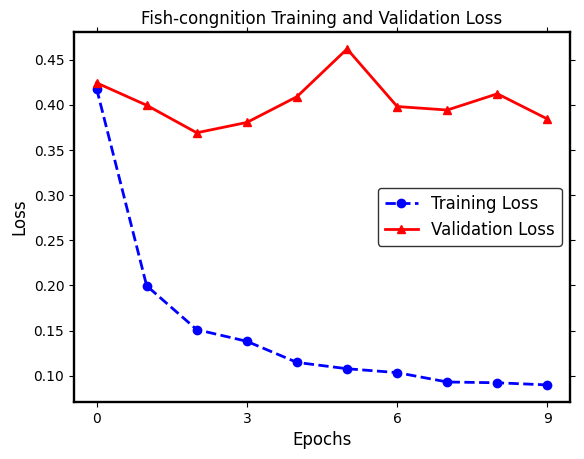

In [96]:
import numpy as np
import matplotlib.pyplot as plt
# plt.rc('font',family='Times New Roman')

data = [[ x/n_total_step for x in train_loss_data ],
        [ x/n_total_step for x in val_loss_data ]]    # 数据序列参数
label = ['Training Loss','Validation Loss']   # 标签序列参数
color = ['blue','red']        # 颜色参数序列
save_path = 'train_loss.jpg'
fig,ax = plt.subplots()
f_line(ax,data,label,color,save_path)      # 调用函数 


#### train acc and valid acc

/home/zhs/anaconda3/envs/pytorch-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


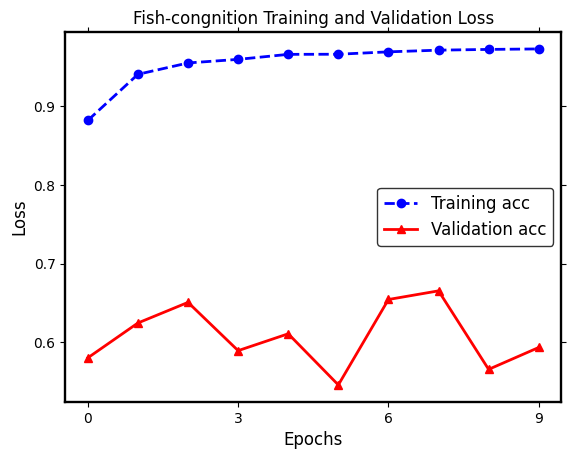

In [98]:

data = [train_acc_data,val_acc_data]    # 数据序列参数
label = ['Training acc','Validation acc']   # 标签序列参数
color = ['blue','red']        # 颜色参数序列
save_path2 = 'train_acc.jpg'
fig,ax = plt.subplots()
f_line(ax,data,label,color,save_path2)      # 调用函数 


#### Test 


#### 加载模型

In [102]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet34(pretrained=True)
input_lastLayer = model.fc.in_features
model.fc = nn.Linear(input_lastLayer, 23)
model = model.to(device)
model.load_state_dict(torch.load('resnet_on_fish_loss.pth'))
model.load_state_dict(torch.load('resnet_on_fish_acc.pth'))
model

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 1.95 GiB total capacity; 946.93 MiB already allocated; 26.19 MiB free; 958.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [106]:
torch.cuda.empty_cache()

In [1]:
total = 0
correct = 0
torch.cuda.empty_cache()
all_mis_preds = []
all_mis_labels = []
all_mis_images = []

for images, labels in tqdm(test_dataloader):
    images = images.to(device)
    labels = labels.to(device)
    out = model(images)
    preds = torch.argmax(out, dim=1)
    total += images.size(0)
    correct += (preds == labels).sum().item()
    
    mis_preds_indice = torch.flatten((preds != labels).nonzero())
    mis_preds = preds[mis_preds_indice]
    mis_labels = labels[mis_preds_indice]
    mis_images = images[mis_preds_indice]
    
    all_mis_preds.extend(mis_preds)
    all_mis_labels.extend(mis_labels)
    
#     for i in range(mis_images.size(0)):
#         all_mis_images.append(unnormalize(mis_images[i]))
    
print(f'{correct}/{total}={correct/total}')

NameError: name 'torch' is not defined